<a href="https://colab.research.google.com/github/nurikahraman/FoodTracker/blob/main/yolo_nas_custom_dataset_fine_tuning_with_qat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src='https://raw.githubusercontent.com/Deci-AI/super-gradients/master/documentation/assets/SG_img/SG%20-%20Horizontal%20Glow.png'>

# Quantization Aware Training YoloNAS on Custom Dataset



**Background**: Our research team developed a new deep learning architecture that competes with YOLOv8 using our efficient AutoNAC algorithm.
The new model, named YoloNAS, incorporates quantization-aware RepVGG blocks into the model architecture to ensure compatibility with Post-Training Quantization, making it more flexible and usable for different hardware configurations.


In this tutorial, we will demonstrate how to fine-tune the small variant of the YoloNAS, YoloNAS_S on a custom dataset from Hugging Face hub.

0. Installations and dataset setup.
1. Initialize train and validation dataloaders.
2. Define training hyper-parameters.
3. Instantiate a pre-trained YoloNAS_S model and launch training.
4. Run prediction on a real world input.
5. Load the best checkpoint from 3., perform post-training quantization and quantization-aware training.


Prerequisites:
- QAT/PTQ tutorials: [classification notebook](https://github.com/Deci-AI/super-gradients/blob/master/tutorials/PTQ_and_QAT_for_classification.ipynb), [Thorough tutorial](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/ptq_qat.md)
- Training object detection models in SG: [Transfer learning notebook](https://bit.ly/3SkMohx).

It is also recommended to see the QAT/PTQ [tutorial](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj125-xvIv_AhVZhP0HHWQnCZYQFnoECBYQAQ&url=https%3A%2F%2Fwww.nvidia.com%2Fen-us%2Fon-demand%2Fsession%2Fgtcspring21-s31653%2F&usg=AOvVaw1i_93iFvK5HJDm_5-SXyMN) from NVidia.

# Installations

# **Google Drive’a Bağlanma**
Veri seti Google Drive’da yer aldığı için öncelikle Drive’a bağlanıyoruz.

In [53]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!pip install -qq super-gradients==3.7.1 datasets[vision]~=2.1 pandas~=2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 871.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 18.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 68.4 MB

# Dataset Setup

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="RpZ3hhiuejsjfnFsncIH")
project = rf.workspace("akilli-atolye").project("supergradients-example")
version = project.version(3)
dataset = version.download("coco")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to SuperGradients-Example--3 in coco:: 100%|██████████| 2282/2282 [00:02<00:00, 1005.49it/s]


In [3]:
from datasets import load_dataset

dataset = load_dataset("/content/SuperGradients-Example--3/")

[2024-06-22 22:36:50] INFO - config.py - PyTorch version 2.3.0+cu121 available.
[2024-06-22 22:36:50] INFO - config.py - Polars version 0.20.2 available.
[2024-06-22 22:36:50] INFO - config.py - TensorFlow version 2.15.0 available.
[2024-06-22 22:36:50] INFO - config.py - JAX version 0.4.26 available.


Resolving data files:   0%|          | 0/1717 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/449 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/111 [00:00<?, ?it/s]

In [4]:
import os
import json

def list_json_files(directory):
    # Dizindeki JSON dosyalarını listele
    json_files = [f for f in os.listdir(directory) if f.endswith('.json')]
    return json_files

def print_json_files(directory):
    json_files = list_json_files(directory)

    if not json_files:
        print(f"{directory} dizininde JSON dosyası bulunamadı.")
        return

    for json_file in json_files:
        json_path = os.path.join(directory, json_file)
        print(f"Dosya: {json_path}")
    return json_path
        # # JSON dosyasını oku ve ekrana yazdır
        # with open(json_path, 'r') as f:
        #     data = json.load(f)
        #     print(json.dumps(data, indent=4))

# Kullanım
train_json_path = '/content/SuperGradients-Example--3/train'  # JSON dosyalarının bulunduğu dizin
valid_json_path = '/content/SuperGradients-Example--3/valid'  # JSON dosyalarının bulunduğu dizin
train_json_path = print_json_files(train_json_path)
valid_json_path = print_json_files(valid_json_path)

In [5]:

def get_class_names(coco_annotation_file):
    # COCO anotasyon dosyasını oku
    with open(coco_annotation_file, 'r') as f:
        coco_data = json.load(f)

    # Kategori isimlerini çıkar
    categories = coco_data.get('categories', [])
#    CLASS_NAMES = [category['name'] for category in categories]
    CLASS_NAMES = [category['name'] for category in categories if category['name'] != 'YoloNAS']

    return CLASS_NAMES

TRAIN_CLASS_NAMES = get_class_names(train_json_path)
TRAIN_NUM_CLASSES = len(TRAIN_CLASS_NAMES)
VALID_CLASS_NAMES = get_class_names(valid_json_path)
VALID_NUM_CLASSES = len(VALID_CLASS_NAMES)

print("Sınıf İsimleri:", TRAIN_CLASS_NAMES)
print("Sınıf Sayısı:", TRAIN_NUM_CLASSES)

Sınıf İsimleri: ['bulgur', 'burgu makarna', 'cubuk makarna', 'dolmalik biber', 'domates', 'fiyonk makarna', 'havuc', 'kabak', 'ketcap', 'kirmizi mercimek', 'kiyma', 'lahana', 'limon', 'mantar', 'manti', 'maydanoz', 'mayonez', 'muz', 'nohut', 'patates', 'patlican', 'peynir', 'pirinc', 'salatalik', 'salca', 'sarimsak', 'sogan', 'sucuk', 'sut', 'tavuk', 'teremyag', 'yesil biber', 'yogurt', 'yumurta', 'zeytin', 'zeytinyagi']
Sınıf Sayısı: 36


# Setup train and validation datasets

Next, we instantiate torch DataLoader objects, one for training and one for validation which will be used for training our model.


In [6]:
from super_gradients.training.datasets.detection_datasets.coco_format_detection import COCOFormatDetectionDataset
from super_gradients.training.transforms.transforms import (
    DetectionRandomAffine,
    DetectionHSV,
    DetectionHorizontalFlip,
    DetectionPaddedRescale,
    DetectionStandardize,
    DetectionTargetsFormatTransform,
)
from super_gradients.training.utils.collate_fn import DetectionCollateFN

train_dataset_params = dict(
    data_dir="/content/SuperGradients-Example--3",
    images_dir="/content/SuperGradients-Example--3/train",
    json_annotation_file=train_json_path,
    input_dim=(800, 800),
    ignore_empty_annotations=False,
    with_crowd=False,
    class_inclusion_list=TRAIN_CLASS_NAMES,
    transforms=[
        DetectionRandomAffine(degrees=0.0, scales=(0.5, 1.5), shear=0.0, target_size=(800, 800), filter_box_candidates=False, border_value=128),
        DetectionHSV(prob=1.0, hgain=5, vgain=30, sgain=30),
        DetectionHorizontalFlip(prob=0.5),
        DetectionPaddedRescale(input_dim=(800, 800)),
        DetectionStandardize(max_value=255),
        DetectionTargetsFormatTransform(input_dim=(800, 800), output_format="LABEL_CXCYWH"),
    ],
)

valid_dataset_params = dict(
    data_dir="/content/SuperGradients-Example--3",
    images_dir="/content/SuperGradients-Example--3/valid",
    json_annotation_file=valid_json_path,
    input_dim=(800, 800),
    ignore_empty_annotations=False,
    with_crowd=False,
    class_inclusion_list=VALID_CLASS_NAMES,
    transforms=[
        DetectionPaddedRescale(input_dim=(800, 800), max_targets=300),
        DetectionStandardize(max_value=255),
        DetectionTargetsFormatTransform(input_dim=(800, 800), output_format="LABEL_CXCYWH"),
    ],
)

trainset = COCOFormatDetectionDataset(**train_dataset_params)
valset = COCOFormatDetectionDataset(**valid_dataset_params)


[2024-06-22 22:36:55] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 1716/1716 [00:00<00:00, 11415.75it/s]
[2024-06-22 22:36:55] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 448/448 [00:00<00:00, 9764.43it/s]


In [7]:
from torch.utils.data import DataLoader

NUM_WORKERS = 0
BATCH_SIZE = 14

train_dataloader_params = {
    "shuffle": True,
    "batch_size": BATCH_SIZE,
    "drop_last": True,
    "pin_memory": True,
    "collate_fn": DetectionCollateFN(),
    "num_workers": NUM_WORKERS,
    "persistent_workers": NUM_WORKERS > 0,
}

val_dataloader_params = {
    "shuffle": False,
    "batch_size": BATCH_SIZE,
    "drop_last": False,
    "pin_memory": True,
    "collate_fn": DetectionCollateFN(),
    "num_workers": NUM_WORKERS,
    "persistent_workers": NUM_WORKERS > 0,
}

train_loader = DataLoader(trainset, **train_dataloader_params)
valid_loader = DataLoader(valset, **val_dataloader_params)

# Defining training hyperparameters

In [29]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    "warmup_initial_lr": 1e-5,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.5,
    "optimizer": "AdamW",
    "zero_weight_decay_on_bias_and_bn": True,
    "lr_warmup_epochs": 1,
    "warmup_mode": "LinearEpochLRWarmup",
    "optimizer_params": {"weight_decay": 0.0001},
    "ema": False,
    "average_best_models": False,
    "ema_params": {"beta": 25, "decay_type": "exp"},
    "max_epochs": 20,
    "mixed_precision": True,
    "loss": PPYoloELoss(use_static_assigner=False, num_classes=TRAIN_NUM_CLASSES, reg_max=16),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=TRAIN_NUM_CLASSES,
            normalize_targets=True,
            include_classwise_ap=True,
            class_names=TRAIN_CLASS_NAMES,
            post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, nms_top_k=1000, max_predictions=300, nms_threshold=0.7),
        )
    ],
    "metric_to_watch": "mAP@0.50",
}

# Instantiate YoloNAS model and launch training

We instantiate a YoloNAS_S model, pre-trained on the [COCO detection dataset](https://cocodataset.org/#home).
Notice we specify num_classes which is different from the 80 classes of COCO, which results in replacing the classification branch of our model's head.

In [30]:
from super_gradients.training import Trainer
from super_gradients.common.object_names import Models
from super_gradients.training import models

trainer = Trainer(experiment_name="yolo_nas_s_fridge_cam_qtq", ckpt_root_dir="yolo_nas_custom_dataset_fine_tuning_with_qat")
model = models.get(Models.YOLO_NAS_S, num_classes=TRAIN_NUM_CLASSES, pretrained_weights="coco")

[2024-06-22 22:59:51] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-06-22 22:59:51] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-06-22 22:59:51] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


In [31]:
trainer.train(model=model, training_params=train_params, train_loader=train_loader, valid_loader=valid_loader)

[2024-06-22 22:59:54] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240622_225954_575847`
[2024-06-22 22:59:54] INFO - sg_trainer.py - Checkpoints directory: experiments/YoloNAS_s_FridgeCam/RUN_20240622_225954_575847


The console stream is now moved to experiments/YoloNAS_s_FridgeCam/RUN_20240622_225954_575847/console_Jun22_22_59_54.txt


[2024-06-22 22:59:55] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            1716       (len(train_set))
    - Batch size per GPU:           14         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             14         (num_gpus * batch_size)
    - Effective Batch size:         14         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         122        (len(train_loader))
    - Gradient updates per epoch:   122        (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_S  (19.03M parameters, 19.03M optimized)
    - Learning Rates and Weight Decays:
      - default: (19.03M parameters). LR: 0.0005 (19.03M parameters) WD: 0.0, (42.23K parameters), WD: 0.0001, (18.99M parameters)

[2024-06-22 22:59:55] INFO - sg_trainer.py - Started training for 2

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.2824
│   ├── Ppyoloeloss/loss_iou = 0.368
│   ├── Ppyoloeloss/loss_dfl = 0.5853
│   └── Ppyoloeloss/loss = 3.2357
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.8177
    ├── Ppyoloeloss/loss_iou = 0.3318
    ├── Ppyoloeloss/loss_dfl = 0.5591
    ├── Ppyoloeloss/loss = 2.7087
    ├── Precision@0.50 = 0.0345
    ├── Recall@0.50 = 0.2658
    ├── Map@0.50 = 0.0873
    ├── F1@0.50 = 0.0472
    ├── Ap@0.50_bulgur = 0.0
    ├── Ap@0.50_burgu makarna = 0.0
    ├── Ap@0.50_cubuk makarna = 0.0
    ├── Ap@0.50_dolmalik biber = 0.1867
    ├── Ap@0.50_domates = 0.515
    ├── Ap@0.50_fiyonk makarna = 0.0
    ├── Ap@0.50_havuc = 0.0033
    ├── Ap@0.50_kabak = 0.4376
    ├── Ap@0.50_ketcap = 0.0006
    ├── Ap@0.50_kirmizi mercimek = 0.0126
    ├── Ap@0.50_kiyma = 0.0421
    ├── Ap@0.50_lahana = 0.0
    ├── Ap@0.50_limon = 0.2837
    ├── Ap@0.50_mantar = 0.1728
    ├── Ap@0.50_manti = 0.0022
    ├── Ap@0.50_maydanoz = 0.0672
    ├── Ap@0.50

Validating epoch 1: 100%|██████████| 32/32 [00:24<00:00,  1.31it/s]


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.6947
│   │   ├── Epoch N-1      = 2.2824 (↘ -0.5877)
│   │   └── Best until now = 2.2824 (↘ -0.5877)
│   ├── Ppyoloeloss/loss_iou = 0.4651
│   │   ├── Epoch N-1      = 0.368  (↗ 0.0971)
│   │   └── Best until now = 0.368  (↗ 0.0971)
│   ├── Ppyoloeloss/loss_dfl = 0.645
│   │   ├── Epoch N-1      = 0.5853 (↗ 0.0597)
│   │   └── Best until now = 0.5853 (↗ 0.0597)
│   └── Ppyoloeloss/loss = 2.8049
│       ├── Epoch N-1      = 3.2357 (↘ -0.4308)
│       └── Best until now = 3.2357 (↘ -0.4308)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.9749
    │   ├── Epoch N-1      = 1.8177 (↗ 0.1571)
    │   └── Best until now = 1.8177 (↗ 0.1571)
    ├── Ppyoloeloss/loss_iou = 0.508
    │   ├── Epoch N-1      = 0.3318 (↗ 0.1762)
    │   └── Best until now = 0.3318 (↗ 0.1762)
    ├── Ppyoloeloss/loss_dfl = 0.7393
    │   ├── Epoch N-1      = 0.5591 (↗ 0.1802)
    │   └── Best until now = 0.5591 (↗ 0.1802)
    ├── Ppyoloeloss/loss = 3.2222


Validating epoch 2: 100%|██████████| 32/32 [00:24<00:00,  1.31it/s]
[2024-06-22 23:09:43] INFO - base_sg_logger.py - Checkpoint saved in experiments/YoloNAS_s_FridgeCam/RUN_20240622_225954_575847/ckpt_best.pth
[2024-06-22 23:09:43] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.12163607031106949
Train epoch 3:   0%|          | 0/122 [00:00<?, ?it/s]

SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.5014
│   │   ├── Epoch N-1      = 1.6947 (↘ -0.1933)
│   │   └── Best until now = 1.6947 (↘ -0.1933)
│   ├── Ppyoloeloss/loss_iou = 0.4236
│   │   ├── Epoch N-1      = 0.4651 (↘ -0.0415)
│   │   └── Best until now = 0.368  (↗ 0.0556)
│   ├── Ppyoloeloss/loss_dfl = 0.6
│   │   ├── Epoch N-1      = 0.645  (↘ -0.045)
│   │   └── Best until now = 0.5853 (↗ 0.0147)
│   └── Ppyoloeloss/loss = 2.525
│       ├── Epoch N-1      = 2.8049 (↘ -0.2799)
│       └── Best until now = 2.8049 (↘ -0.2799)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.432
    │   ├── Epoch N-1      = 1.9749 (↘ -0.5428)
    │   └── Best until now = 1.8177 (↘ -0.3857)
    ├── Ppyoloeloss/loss_iou = 0.4234
    │   ├── Epoch N-1      = 0.508  (↘ -0.0847)
    │   └── Best until now = 0.3318 (↗ 0.0915)
    ├── Ppyoloeloss/loss_dfl = 0.616
    │   ├── Epoch N-1      = 0.7393 (↘ -0.1233)
    │   └── Best until now = 0.5591 (↗ 0.0569)
    ├── Ppyoloeloss/loss = 2.4714

Validating epoch 3: 100%|██████████| 32/32 [00:24<00:00,  1.30it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3823
│   │   ├── Epoch N-1      = 1.5014 (↘ -0.1191)
│   │   └── Best until now = 1.5014 (↘ -0.1191)
│   ├── Ppyoloeloss/loss_iou = 0.4162
│   │   ├── Epoch N-1      = 0.4236 (↘ -0.0074)
│   │   └── Best until now = 0.368  (↗ 0.0482)
│   ├── Ppyoloeloss/loss_dfl = 0.5955
│   │   ├── Epoch N-1      = 0.6    (↘ -0.0045)
│   │   └── Best until now = 0.5853 (↗ 0.0102)
│   └── Ppyoloeloss/loss = 2.394
│       ├── Epoch N-1      = 2.525  (↘ -0.1309)
│       └── Best until now = 2.525  (↘ -0.1309)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.627
    │   ├── Epoch N-1      = 1.432  (↗ 0.195)
    │   └── Best until now = 1.432  (↗ 0.195)
    ├── Ppyoloeloss/loss_iou = 0.439
    │   ├── Epoch N-1      = 0.4234 (↗ 0.0156)
    │   └── Best until now = 0.3318 (↗ 0.1072)
    ├── Ppyoloeloss/loss_dfl = 0.6355
    │   ├── Epoch N-1      = 0.616  (↗ 0.0195)
    │   └── Best until now = 0.5591 (↗ 0.0764)
    ├── Ppyoloeloss/loss = 2.7015
 

Validating epoch 4: 100%|██████████| 32/32 [00:24<00:00,  1.30it/s]
[2024-06-22 23:16:15] INFO - base_sg_logger.py - Checkpoint saved in experiments/YoloNAS_s_FridgeCam/RUN_20240622_225954_575847/ckpt_best.pth
[2024-06-22 23:16:15] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.1252758800983429
Train epoch 5:   0%|          | 0/122 [00:00<?, ?it/s]

SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3281
│   │   ├── Epoch N-1      = 1.3823 (↘ -0.0543)
│   │   └── Best until now = 1.3823 (↘ -0.0543)
│   ├── Ppyoloeloss/loss_iou = 0.4049
│   │   ├── Epoch N-1      = 0.4162 (↘ -0.0114)
│   │   └── Best until now = 0.368  (↗ 0.0368)
│   ├── Ppyoloeloss/loss_dfl = 0.5767
│   │   ├── Epoch N-1      = 0.5955 (↘ -0.0188)
│   │   └── Best until now = 0.5853 (↘ -0.0086)
│   └── Ppyoloeloss/loss = 2.3096
│       ├── Epoch N-1      = 2.394  (↘ -0.0844)
│       └── Best until now = 2.394  (↘ -0.0844)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4691
    │   ├── Epoch N-1      = 1.627  (↘ -0.1579)
    │   └── Best until now = 1.432  (↗ 0.0371)
    ├── Ppyoloeloss/loss_iou = 0.4361
    │   ├── Epoch N-1      = 0.439  (↘ -0.0029)
    │   └── Best until now = 0.3318 (↗ 0.1043)
    ├── Ppyoloeloss/loss_dfl = 0.6429
    │   ├── Epoch N-1      = 0.6355 (↗ 0.0074)
    │   └── Best until now = 0.5591 (↗ 0.0838)
    ├── Ppyoloeloss/loss = 

Validating epoch 5: 100%|██████████| 32/32 [00:24<00:00,  1.32it/s]
[2024-06-22 23:19:26] INFO - base_sg_logger.py - Checkpoint saved in experiments/YoloNAS_s_FridgeCam/RUN_20240622_225954_575847/ckpt_best.pth
[2024-06-22 23:19:26] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.1541910618543625
Train epoch 6:   0%|          | 0/122 [00:00<?, ?it/s]

SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2944
│   │   ├── Epoch N-1      = 1.3281 (↘ -0.0337)
│   │   └── Best until now = 1.3281 (↘ -0.0337)
│   ├── Ppyoloeloss/loss_iou = 0.3983
│   │   ├── Epoch N-1      = 0.4049 (↘ -0.0065)
│   │   └── Best until now = 0.368  (↗ 0.0303)
│   ├── Ppyoloeloss/loss_dfl = 0.5822
│   │   ├── Epoch N-1      = 0.5767 (↗ 0.0055)
│   │   └── Best until now = 0.5767 (↗ 0.0055)
│   └── Ppyoloeloss/loss = 2.2749
│       ├── Epoch N-1      = 2.3096 (↘ -0.0347)
│       └── Best until now = 2.3096 (↘ -0.0347)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3515
    │   ├── Epoch N-1      = 1.4691 (↘ -0.1177)
    │   └── Best until now = 1.432  (↘ -0.0806)
    ├── Ppyoloeloss/loss_iou = 0.4244
    │   ├── Epoch N-1      = 0.4361 (↘ -0.0117)
    │   └── Best until now = 0.3318 (↗ 0.0926)
    ├── Ppyoloeloss/loss_dfl = 0.6342
    │   ├── Epoch N-1      = 0.6429 (↘ -0.0087)
    │   └── Best until now = 0.5591 (↗ 0.0751)
    ├── Ppyoloeloss/loss = 

Validating epoch 6: 100%|██████████| 32/32 [00:24<00:00,  1.30it/s]
[2024-06-22 23:22:39] INFO - base_sg_logger.py - Checkpoint saved in experiments/YoloNAS_s_FridgeCam/RUN_20240622_225954_575847/ckpt_best.pth
[2024-06-22 23:22:39] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.16038694977760315
Train epoch 7:   0%|          | 0/122 [00:00<?, ?it/s]

SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2516
│   │   ├── Epoch N-1      = 1.2944 (↘ -0.0428)
│   │   └── Best until now = 1.2944 (↘ -0.0428)
│   ├── Ppyoloeloss/loss_iou = 0.4015
│   │   ├── Epoch N-1      = 0.3983 (↗ 0.0032)
│   │   └── Best until now = 0.368  (↗ 0.0335)
│   ├── Ppyoloeloss/loss_dfl = 0.5796
│   │   ├── Epoch N-1      = 0.5822 (↘ -0.0026)
│   │   └── Best until now = 0.5767 (↗ 0.0029)
│   └── Ppyoloeloss/loss = 2.2327
│       ├── Epoch N-1      = 2.2749 (↘ -0.0423)
│       └── Best until now = 2.2749 (↘ -0.0423)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3862
    │   ├── Epoch N-1      = 1.3515 (↗ 0.0347)
    │   └── Best until now = 1.3515 (↗ 0.0347)
    ├── Ppyoloeloss/loss_iou = 0.4189
    │   ├── Epoch N-1      = 0.4244 (↘ -0.0056)
    │   └── Best until now = 0.3318 (↗ 0.087)
    ├── Ppyoloeloss/loss_dfl = 0.6164
    │   ├── Epoch N-1      = 0.6342 (↘ -0.0178)
    │   └── Best until now = 0.5591 (↗ 0.0573)
    ├── Ppyoloeloss/loss = 2.4

Validating epoch 7: 100%|██████████| 32/32 [00:24<00:00,  1.29it/s]
[2024-06-22 23:25:52] INFO - base_sg_logger.py - Checkpoint saved in experiments/YoloNAS_s_FridgeCam/RUN_20240622_225954_575847/ckpt_best.pth
[2024-06-22 23:25:52] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.21409371495246887
Train epoch 8:   0%|          | 0/122 [00:00<?, ?it/s]

SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1844
│   │   ├── Epoch N-1      = 1.2516 (↘ -0.0671)
│   │   └── Best until now = 1.2516 (↘ -0.0671)
│   ├── Ppyoloeloss/loss_iou = 0.3952
│   │   ├── Epoch N-1      = 0.4015 (↘ -0.0063)
│   │   └── Best until now = 0.368  (↗ 0.0271)
│   ├── Ppyoloeloss/loss_dfl = 0.5633
│   │   ├── Epoch N-1      = 0.5796 (↘ -0.0163)
│   │   └── Best until now = 0.5767 (↘ -0.0134)
│   └── Ppyoloeloss/loss = 2.1429
│       ├── Epoch N-1      = 2.2327 (↘ -0.0898)
│       └── Best until now = 2.2327 (↘ -0.0898)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4842
    │   ├── Epoch N-1      = 1.3862 (↗ 0.0981)
    │   └── Best until now = 1.3515 (↗ 0.1328)
    ├── Ppyoloeloss/loss_iou = 0.4002
    │   ├── Epoch N-1      = 0.4189 (↘ -0.0186)
    │   └── Best until now = 0.3318 (↗ 0.0684)
    ├── Ppyoloeloss/loss_dfl = 0.6002
    │   ├── Epoch N-1      = 0.6164 (↘ -0.0162)
    │   └── Best until now = 0.5591 (↗ 0.0411)
    ├── Ppyoloeloss/loss = 

Validating epoch 8: 100%|██████████| 32/32 [00:24<00:00,  1.31it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1479
│   │   ├── Epoch N-1      = 1.1844 (↘ -0.0365)
│   │   └── Best until now = 1.1844 (↘ -0.0365)
│   ├── Ppyoloeloss/loss_iou = 0.38
│   │   ├── Epoch N-1      = 0.3952 (↘ -0.0152)
│   │   └── Best until now = 0.368  (↗ 0.012)
│   ├── Ppyoloeloss/loss_dfl = 0.5562
│   │   ├── Epoch N-1      = 0.5633 (↘ -0.0071)
│   │   └── Best until now = 0.5633 (↘ -0.0071)
│   └── Ppyoloeloss/loss = 2.0841
│       ├── Epoch N-1      = 2.1429 (↘ -0.0588)
│       └── Best until now = 2.1429 (↘ -0.0588)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.7079
    │   ├── Epoch N-1      = 1.4842 (↗ 0.2237)
    │   └── Best until now = 1.3515 (↗ 0.3564)
    ├── Ppyoloeloss/loss_iou = 0.4054
    │   ├── Epoch N-1      = 0.4002 (↗ 0.0051)
    │   └── Best until now = 0.3318 (↗ 0.0735)
    ├── Ppyoloeloss/loss_dfl = 0.606
    │   ├── Epoch N-1      = 0.6002 (↗ 0.0058)
    │   └── Best until now = 0.5591 (↗ 0.0469)
    ├── Ppyoloeloss/loss = 2.7193

Validating epoch 9: 100%|██████████| 32/32 [00:24<00:00,  1.30it/s]
[2024-06-22 23:32:15] INFO - base_sg_logger.py - Checkpoint saved in experiments/YoloNAS_s_FridgeCam/RUN_20240622_225954_575847/ckpt_best.pth
[2024-06-22 23:32:15] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.3168783187866211
Train epoch 10:   0%|          | 0/122 [00:00<?, ?it/s]

SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1107
│   │   ├── Epoch N-1      = 1.1479 (↘ -0.0373)
│   │   └── Best until now = 1.1479 (↘ -0.0373)
│   ├── Ppyoloeloss/loss_iou = 0.3746
│   │   ├── Epoch N-1      = 0.38   (↘ -0.0053)
│   │   └── Best until now = 0.368  (↗ 0.0066)
│   ├── Ppyoloeloss/loss_dfl = 0.5439
│   │   ├── Epoch N-1      = 0.5562 (↘ -0.0123)
│   │   └── Best until now = 0.5562 (↘ -0.0123)
│   └── Ppyoloeloss/loss = 2.0292
│       ├── Epoch N-1      = 2.0841 (↘ -0.0548)
│       └── Best until now = 2.0841 (↘ -0.0548)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1488
    │   ├── Epoch N-1      = 1.7079 (↘ -0.5591)
    │   └── Best until now = 1.3515 (↘ -0.2026)
    ├── Ppyoloeloss/loss_iou = 0.3817
    │   ├── Epoch N-1      = 0.4054 (↘ -0.0236)
    │   └── Best until now = 0.3318 (↗ 0.0499)
    ├── Ppyoloeloss/loss_dfl = 0.5713
    │   ├── Epoch N-1      = 0.606  (↘ -0.0347)
    │   └── Best until now = 0.5591 (↗ 0.0121)
    ├── Ppyoloeloss/loss 

Validating epoch 10: 100%|██████████| 32/32 [00:24<00:00,  1.31it/s]
[2024-06-22 23:35:28] INFO - base_sg_logger.py - Checkpoint saved in experiments/YoloNAS_s_FridgeCam/RUN_20240622_225954_575847/ckpt_best.pth
[2024-06-22 23:35:28] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.3529166579246521
Train epoch 11:   0%|          | 0/122 [00:00<?, ?it/s]

SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0548
│   │   ├── Epoch N-1      = 1.1107 (↘ -0.0558)
│   │   └── Best until now = 1.1107 (↘ -0.0558)
│   ├── Ppyoloeloss/loss_iou = 0.3699
│   │   ├── Epoch N-1      = 0.3746 (↘ -0.0047)
│   │   └── Best until now = 0.368  (↗ 0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.5376
│   │   ├── Epoch N-1      = 0.5439 (↘ -0.0063)
│   │   └── Best until now = 0.5439 (↘ -0.0063)
│   └── Ppyoloeloss/loss = 1.9623
│       ├── Epoch N-1      = 2.0292 (↘ -0.0669)
│       └── Best until now = 2.0292 (↘ -0.0669)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1122
    │   ├── Epoch N-1      = 1.1488 (↘ -0.0367)
    │   └── Best until now = 1.1488 (↘ -0.0367)
    ├── Ppyoloeloss/loss_iou = 0.3731
    │   ├── Epoch N-1      = 0.3817 (↘ -0.0087)
    │   └── Best until now = 0.3318 (↗ 0.0412)
    ├── Ppyoloeloss/loss_dfl = 0.5707
    │   ├── Epoch N-1      = 0.5713 (↘ -0.0005)
    │   └── Best until now = 0.5591 (↗ 0.0116)
    ├── Ppyoloeloss/loss

Validating epoch 11: 100%|██████████| 32/32 [00:24<00:00,  1.32it/s]
[2024-06-22 23:38:40] INFO - base_sg_logger.py - Checkpoint saved in experiments/YoloNAS_s_FridgeCam/RUN_20240622_225954_575847/ckpt_best.pth
[2024-06-22 23:38:40] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.39737626910209656
Train epoch 12:   0%|          | 0/122 [00:00<?, ?it/s]

SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0361
│   │   ├── Epoch N-1      = 1.0548 (↘ -0.0187)
│   │   └── Best until now = 1.0548 (↘ -0.0187)
│   ├── Ppyoloeloss/loss_iou = 0.3658
│   │   ├── Epoch N-1      = 0.3699 (↘ -0.0041)
│   │   └── Best until now = 0.368  (↘ -0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.5338
│   │   ├── Epoch N-1      = 0.5376 (↘ -0.0038)
│   │   └── Best until now = 0.5376 (↘ -0.0038)
│   └── Ppyoloeloss/loss = 1.9358
│       ├── Epoch N-1      = 1.9623 (↘ -0.0265)
│       └── Best until now = 1.9623 (↘ -0.0265)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0363
    │   ├── Epoch N-1      = 1.1122 (↘ -0.0759)
    │   └── Best until now = 1.1122 (↘ -0.0759)
    ├── Ppyoloeloss/loss_iou = 0.3766
    │   ├── Epoch N-1      = 0.3731 (↗ 0.0035)
    │   └── Best until now = 0.3318 (↗ 0.0447)
    ├── Ppyoloeloss/loss_dfl = 0.5682
    │   ├── Epoch N-1      = 0.5707 (↘ -0.0025)
    │   └── Best until now = 0.5591 (↗ 0.0091)
    ├── Ppyoloeloss/loss

Validating epoch 12: 100%|██████████| 32/32 [00:24<00:00,  1.29it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0243
│   │   ├── Epoch N-1      = 1.0361 (↘ -0.0118)
│   │   └── Best until now = 1.0361 (↘ -0.0118)
│   ├── Ppyoloeloss/loss_iou = 0.3586
│   │   ├── Epoch N-1      = 0.3658 (↘ -0.0072)
│   │   └── Best until now = 0.3658 (↘ -0.0072)
│   ├── Ppyoloeloss/loss_dfl = 0.5268
│   │   ├── Epoch N-1      = 0.5338 (↘ -0.0071)
│   │   └── Best until now = 0.5338 (↘ -0.0071)
│   └── Ppyoloeloss/loss = 1.9096
│       ├── Epoch N-1      = 1.9358 (↘ -0.0262)
│       └── Best until now = 1.9358 (↘ -0.0262)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1362
    │   ├── Epoch N-1      = 1.0363 (↗ 0.0999)
    │   └── Best until now = 1.0363 (↗ 0.0999)
    ├── Ppyoloeloss/loss_iou = 0.3731
    │   ├── Epoch N-1      = 0.3766 (↘ -0.0035)
    │   └── Best until now = 0.3318 (↗ 0.0412)
    ├── Ppyoloeloss/loss_dfl = 0.563
    │   ├── Epoch N-1      = 0.5682 (↘ -0.0052)
    │   └── Best until now = 0.5591 (↗ 0.0039)
    ├── Ppyoloeloss/loss =

Validating epoch 13: 100%|██████████| 32/32 [00:24<00:00,  1.29it/s]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9941
│   │   ├── Epoch N-1      = 1.0243 (↘ -0.0302)
│   │   └── Best until now = 1.0243 (↘ -0.0302)
│   ├── Ppyoloeloss/loss_iou = 0.3542
│   │   ├── Epoch N-1      = 0.3586 (↘ -0.0044)
│   │   └── Best until now = 0.3586 (↘ -0.0044)
│   ├── Ppyoloeloss/loss_dfl = 0.5283
│   │   ├── Epoch N-1      = 0.5268 (↗ 0.0015)
│   │   └── Best until now = 0.5268 (↗ 0.0015)
│   └── Ppyoloeloss/loss = 1.8766
│       ├── Epoch N-1      = 1.9096 (↘ -0.033)
│       └── Best until now = 1.9096 (↘ -0.033)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1236
    │   ├── Epoch N-1      = 1.1362 (↘ -0.0125)
    │   └── Best until now = 1.0363 (↗ 0.0874)
    ├── Ppyoloeloss/loss_iou = 0.3825
    │   ├── Epoch N-1      = 0.3731 (↗ 0.0095)
    │   └── Best until now = 0.3318 (↗ 0.0507)
    ├── Ppyoloeloss/loss_dfl = 0.5932
    │   ├── Epoch N-1      = 0.563  (↗ 0.0303)
    │   └── Best until now = 0.5591 (↗ 0.0341)
    ├── Ppyoloeloss/loss = 2.0

Validating epoch 14: 100%|██████████| 32/32 [00:24<00:00,  1.32it/s]
[2024-06-22 23:48:16] INFO - base_sg_logger.py - Checkpoint saved in experiments/YoloNAS_s_FridgeCam/RUN_20240622_225954_575847/ckpt_best.pth
[2024-06-22 23:48:16] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.41384780406951904
Train epoch 15:   0%|          | 0/122 [00:00<?, ?it/s]

SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9721
│   │   ├── Epoch N-1      = 0.9941 (↘ -0.0219)
│   │   └── Best until now = 0.9941 (↘ -0.0219)
│   ├── Ppyoloeloss/loss_iou = 0.3534
│   │   ├── Epoch N-1      = 0.3542 (↘ -0.0008)
│   │   └── Best until now = 0.3542 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.5226
│   │   ├── Epoch N-1      = 0.5283 (↘ -0.0057)
│   │   └── Best until now = 0.5268 (↘ -0.0042)
│   └── Ppyoloeloss/loss = 1.8481
│       ├── Epoch N-1      = 1.8766 (↘ -0.0285)
│       └── Best until now = 1.8766 (↘ -0.0285)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0678
    │   ├── Epoch N-1      = 1.1236 (↘ -0.0559)
    │   └── Best until now = 1.0363 (↗ 0.0315)
    ├── Ppyoloeloss/loss_iou = 0.3873
    │   ├── Epoch N-1      = 0.3825 (↗ 0.0048)
    │   └── Best until now = 0.3318 (↗ 0.0555)
    ├── Ppyoloeloss/loss_dfl = 0.5753
    │   ├── Epoch N-1      = 0.5932 (↘ -0.0179)
    │   └── Best until now = 0.5591 (↗ 0.0162)
    ├── Ppyoloeloss/loss 

Validating epoch 15: 100%|██████████| 32/32 [00:24<00:00,  1.32it/s]
[2024-06-22 23:51:28] INFO - base_sg_logger.py - Checkpoint saved in experiments/YoloNAS_s_FridgeCam/RUN_20240622_225954_575847/ckpt_best.pth
[2024-06-22 23:51:28] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5119345188140869
Train epoch 16:   0%|          | 0/122 [00:00<?, ?it/s]

SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9712
│   │   ├── Epoch N-1      = 0.9721 (↘ -0.001)
│   │   └── Best until now = 0.9721 (↘ -0.001)
│   ├── Ppyoloeloss/loss_iou = 0.3531
│   │   ├── Epoch N-1      = 0.3534 (↘ -0.0003)
│   │   └── Best until now = 0.3534 (↘ -0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.5253
│   │   ├── Epoch N-1      = 0.5226 (↗ 0.0027)
│   │   └── Best until now = 0.5226 (↗ 0.0027)
│   └── Ppyoloeloss/loss = 1.8495
│       ├── Epoch N-1      = 1.8481 (↗ 0.0014)
│       └── Best until now = 1.8481 (↗ 0.0014)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9985
    │   ├── Epoch N-1      = 1.0678 (↘ -0.0692)
    │   └── Best until now = 1.0363 (↘ -0.0377)
    ├── Ppyoloeloss/loss_iou = 0.3604
    │   ├── Epoch N-1      = 0.3873 (↘ -0.0269)
    │   └── Best until now = 0.3318 (↗ 0.0285)
    ├── Ppyoloeloss/loss_dfl = 0.5504
    │   ├── Epoch N-1      = 0.5753 (↘ -0.0249)
    │   └── Best until now = 0.5591 (↘ -0.0087)
    ├── Ppyoloeloss/loss = 1

Validating epoch 16: 100%|██████████| 32/32 [00:24<00:00,  1.31it/s]


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9348
│   │   ├── Epoch N-1      = 0.9712 (↘ -0.0364)
│   │   └── Best until now = 0.9712 (↘ -0.0364)
│   ├── Ppyoloeloss/loss_iou = 0.3481
│   │   ├── Epoch N-1      = 0.3531 (↘ -0.0049)
│   │   └── Best until now = 0.3531 (↘ -0.0049)
│   ├── Ppyoloeloss/loss_dfl = 0.5153
│   │   ├── Epoch N-1      = 0.5253 (↘ -0.01)
│   │   └── Best until now = 0.5226 (↘ -0.0073)
│   └── Ppyoloeloss/loss = 1.7983
│       ├── Epoch N-1      = 1.8495 (↘ -0.0513)
│       └── Best until now = 1.8481 (↘ -0.0498)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.066
    │   ├── Epoch N-1      = 0.9985 (↗ 0.0675)
    │   └── Best until now = 0.9985 (↗ 0.0675)
    ├── Ppyoloeloss/loss_iou = 0.3773
    │   ├── Epoch N-1      = 0.3604 (↗ 0.017)
    │   └── Best until now = 0.3318 (↗ 0.0455)
    ├── Ppyoloeloss/loss_dfl = 0.5684
    │   ├── Epoch N-1      = 0.5504 (↗ 0.018)
    │   └── Best until now = 0.5504 (↗ 0.018)
    ├── Ppyoloeloss/loss = 2.0118

Validating epoch 17: 100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9218
│   │   ├── Epoch N-1      = 0.9348 (↘ -0.013)
│   │   └── Best until now = 0.9348 (↘ -0.013)
│   ├── Ppyoloeloss/loss_iou = 0.3478
│   │   ├── Epoch N-1      = 0.3481 (↘ -0.0003)
│   │   └── Best until now = 0.3481 (↘ -0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.5153
│   │   ├── Epoch N-1      = 0.5153 (↗ 0.0)
│   │   └── Best until now = 0.5153 (↗ 0.0)
│   └── Ppyoloeloss/loss = 1.7849
│       ├── Epoch N-1      = 1.7983 (↘ -0.0134)
│       └── Best until now = 1.7983 (↘ -0.0134)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0425
    │   ├── Epoch N-1      = 1.066  (↘ -0.0236)
    │   └── Best until now = 0.9985 (↗ 0.0439)
    ├── Ppyoloeloss/loss_iou = 0.3667
    │   ├── Epoch N-1      = 0.3773 (↘ -0.0106)
    │   └── Best until now = 0.3318 (↗ 0.0349)
    ├── Ppyoloeloss/loss_dfl = 0.5563
    │   ├── Epoch N-1      = 0.5684 (↘ -0.0122)
    │   └── Best until now = 0.5504 (↗ 0.0059)
    ├── Ppyoloeloss/loss = 1.9654


Validating epoch 18: 100%|██████████| 32/32 [00:24<00:00,  1.31it/s]


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9027
│   │   ├── Epoch N-1      = 0.9218 (↘ -0.0191)
│   │   └── Best until now = 0.9218 (↘ -0.0191)
│   ├── Ppyoloeloss/loss_iou = 0.3443
│   │   ├── Epoch N-1      = 0.3478 (↘ -0.0035)
│   │   └── Best until now = 0.3478 (↘ -0.0035)
│   ├── Ppyoloeloss/loss_dfl = 0.5105
│   │   ├── Epoch N-1      = 0.5153 (↘ -0.0049)
│   │   └── Best until now = 0.5153 (↘ -0.0048)
│   └── Ppyoloeloss/loss = 1.7575
│       ├── Epoch N-1      = 1.7849 (↘ -0.0274)
│       └── Best until now = 1.7849 (↘ -0.0274)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0978
    │   ├── Epoch N-1      = 1.0425 (↗ 0.0554)
    │   └── Best until now = 0.9985 (↗ 0.0993)
    ├── Ppyoloeloss/loss_iou = 0.3698
    │   ├── Epoch N-1      = 0.3667 (↗ 0.003)
    │   └── Best until now = 0.3318 (↗ 0.0379)
    ├── Ppyoloeloss/loss_dfl = 0.5601
    │   ├── Epoch N-1      = 0.5563 (↗ 0.0039)
    │   └── Best until now = 0.5504 (↗ 0.0097)
    ├── Ppyoloeloss/loss = 2

Validating epoch 19: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s]



# Step 4: Run prediction on a real world input.

Now, lets see our trained model in action. We load the best checkpoint from step 3, and simply call predict on a real-world image.

In [28]:
best_model = models.get(Models.YOLO_NAS_S, num_classes=TRAIN_NUM_CLASSES, checkpoint_path="/content/experiments/YoloNAS_s_FridgeCam/RUN_20240622_222854_042771/ckpt_best.pth")

test_metrics_list = [DetectionMetrics_050(
                                          score_thres=0.1,
                                          top_k_predictions=300,
                                          num_cls=TRAIN_NUM_CLASSES,
                                          normalize_targets=True,
                                          post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                           nms_top_k=1000,
                                                                                                           max_predictions=300,
                                                                                                           nms_threshold=0.7))]

regular_metrics = trainer.test(model=best_model, test_loader=valid_loader, test_metrics_list=test_metrics_list)

# trainer.test(model=chosen_model,
#             test_loader=test_data,
#             test_metrics_list=DetectionMetrics_050(
#                                                    num_cls=config.NUM_CLASSES,
#                                                    normalize_targets=True,
#                                                    post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
#                                                                                                           nms_top_k=1000,
#                                                                                                           max_predictions=300,
#                                                                                                           nms_threshold=0.7)))

regular_metrics

[2024-06-22 22:58:57] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/experiments/YoloNAS_s_FridgeCam/RUN_20240622_222854_042771/ckpt_best.pth checkpoint.
Testing:  97%|█████████▋| 31/32 [00:28<00:00,  1.03it/s]

{'Precision@0.50': 0.0368521548807621,
 'Recall@0.50': 0.19115659594535828,
 'mAP@0.50': 0.05762433260679245,
 'F1@0.50': 0.04619746655225754,
 'Best_score_threshold': 0.09999999403953552}

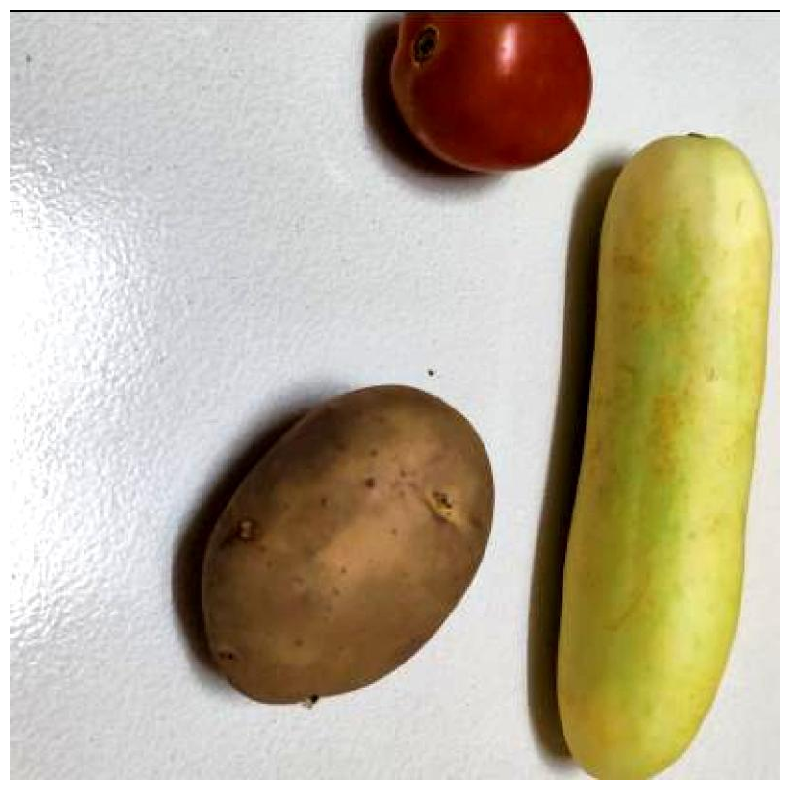

In [32]:
prediction = best_model.predict(dataset["test"][0]["image"], fuse_model=False)
prediction.show()

# Post-training quantization

We will now perform post-training quantization (PTQ) on our best model.
This will result in a quantized model that can be used on hardware that supports INT8 operations.

A post-training quantization process is performed by the `ptq` method of the `Trainer` class.
It converts the model's weights to INT8 and performs model calibration to minimize the accuracy loss.
The calibration is done using a calibration data loader (`calib_loader`).

To evalute the quantized model, we use the `valid_loader` parameter to specify the dataloader for validation.
In this case, we use the same dataloader as we used during regular training to have apples-to-apples comparison.

Quantization is a last step before model deployment. So after PTQ we usually want to export the model to ONNX format, which is a common format for deployment.
The `export_params` parameter is used to specify the various arguments like batch size, whether pre- or post-processing should be applied, etc.
For example, if we set `preprocessing=True` and `postprocessing=True` so our detection model will take `uint8` RGB images and output detections after the NMS.

In [33]:
best_model_checkpoint_path = os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth")
best_model_checkpoint_path

'experiments/YoloNAS_s_FridgeCam/RUN_20240622_225954_575847/ckpt_best.pth'

In [35]:
from super_gradients.conversion import ExportParams

best_model = models.get(Models.YOLO_NAS_S, num_classes=TRAIN_NUM_CLASSES, checkpoint_path=best_model_checkpoint_path)

export_params = ExportParams(batch_size=1, preprocessing=True, postprocessing=True)

ptq_result = trainer.ptq(model=best_model, calib_loader=valid_loader, valid_loader=valid_loader, export_params=export_params)
ptq_metrics = ptq_result.valid_metrics_dict

[2024-06-23 00:12:07] INFO - checkpoint_utils.py - Successfully loaded model weights from experiments/YoloNAS_s_FridgeCam/RUN_20240622_225954_575847/ckpt_best.pth checkpoint.
Testing: 100%|██████████| 32/32 [00:30<00:00,  1.07it/s]
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

Collecting onnx_graphsurgeon==0.3.27

Downloading https://developer.download.nvidia.com/compute/redist/onnx-graphsurgeon/onnx_graphsurgeon-0.3.27-py2.py3-none-any.whl (42 kB)

Output()

Requirement already satisfied: numpy in /usr/local/lib/python3.10/dist-packages (from onnx_graphsurgeon==0.3.27) (1.23.0)

Requirement already satisfied: onnx in /usr/local/lib/python3.10/dist-packages (from onnx_graphsurgeon==0.3.27) (1.15.0)

Requirement already satisfied: protobuf>=3.20.2 in /usr/local/lib/python3.10/dist-packages (from onnx->onnx_graphsurgeon==0.3.27) (3.20.3)

Installing collected packages: onnx_graphsurgeon

Successfully installed onnx_graphsurgeon-0.3.27

WARNING: Use Pytorch's native experimental fake quantization.


/usr/local/lib/python3.10/dist-packages/pytorch_quantization/nn/modules/tensor_quantizer.py:284: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if amax.numel() == 1:
/usr/local/lib/python3.10/dist-packages/pytorch_quantization/nn/modules/tensor_quantizer.py:286: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  inputs, amax.item() / bound, 0,
/usr/local/lib/python3.10/dist-packages/pytorch_quantization/nn/modules/tensor_quantizer.py:292: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flo

### Inspect metrics of model after PTQ

In [36]:
ptq_metrics

{'PPYoloELoss/loss_cls': 0.99874395,
 'PPYoloELoss/loss_iou': 0.36217433,
 'PPYoloELoss/loss_dfl': 0.5500041,
 'PPYoloELoss/loss': 1.9109228,
 'Precision@0.50': 0.06179867312312126,
 'Recall@0.50': 0.8816182613372803,
 'mAP@0.50': 0.5152533650398254,
 'F1@0.50': 0.11214762181043625,
 'AP@0.50_bulgur': 0.2618749141693115,
 'AP@0.50_burgu makarna': 0.2532903254032135,
 'AP@0.50_cubuk makarna': 0.6232505440711975,
 'AP@0.50_dolmalik biber': 0.8000984787940979,
 'AP@0.50_domates': 0.7745577096939087,
 'AP@0.50_fiyonk makarna': 0.1431930810213089,
 'AP@0.50_havuc': 0.6367321014404297,
 'AP@0.50_kabak': 0.6515547633171082,
 'AP@0.50_ketcap': 0.6777934432029724,
 'AP@0.50_kirmizi mercimek': 0.5701107978820801,
 'AP@0.50_kiyma': 0.6210620999336243,
 'AP@0.50_lahana': 0.43960148096084595,
 'AP@0.50_limon': 0.8380712270736694,
 'AP@0.50_mantar': 0.6024723052978516,
 'AP@0.50_manti': 0.3751375079154968,
 'AP@0.50_maydanoz': 0.4554455578327179,
 'AP@0.50_mayonez': 0.3088979423046112,
 'AP@0.50_muz

### Pretict with PTQ model

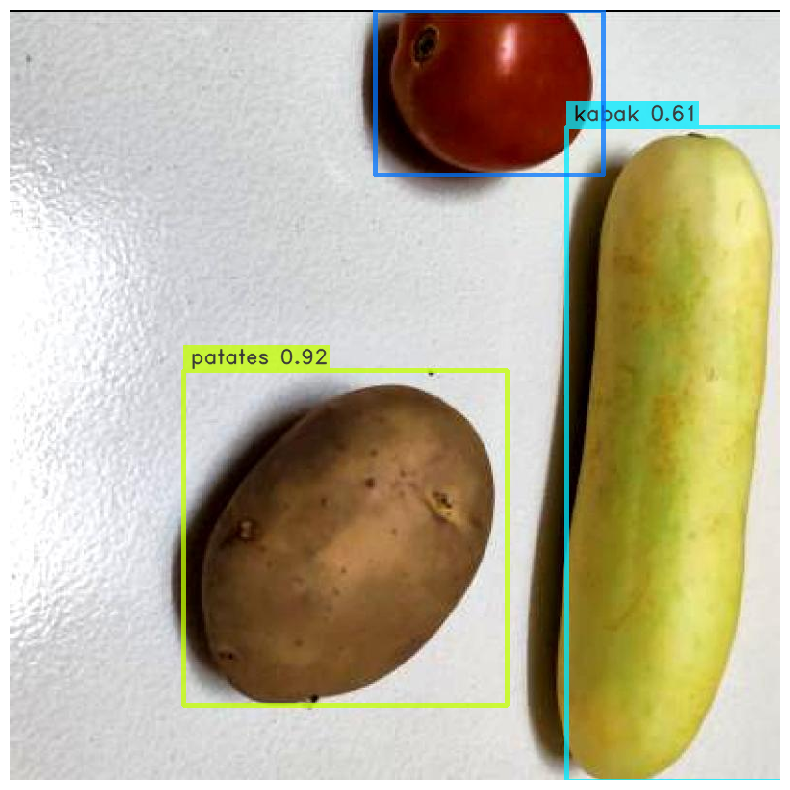

In [37]:
prediction = ptq_result.quantized_model.predict(dataset["test"][0]["image"], fuse_model=False)
prediction.show()

# Quantization-aware training

Since all local variables are lost, we define again `train_params, train_dataset_params, val_dataset_params, train_dataloader_params, val_dataloader_params`.

Next, we call `modify_params_for_qat`, which will manipulate these configurations according to some best practices for QAT. For example, we turn off augmentations for the trainset.
All manipulations being done are printed to the screen the for the user's notice.

Finally, after we instantiate our objects with our modified configurations, we call `trainer.qat(model=net, training_params=train_params, train_loader=train_loader, valid_loader=valid_loader, calib_loader=train_loader)`

Under the hood, the following will occur:
- We will use our `calib_loader` which is set to `train_loader` for calibration, gathering statistics that are used to map our network into Int8 range. This part is what we refer to as "Post-training quantization".
- Next, we validate our PTQ model and export it to ONNX format.
- The exported PTQ model is saved under our checkpoints directory.
- Finally, we perform quantization aware training with our adapted training parameters - since we originally trained for 10 epochs, the general rule of thumb suggests that we quantization-aware train for 10/10=1 epoch. Again, we export the ONNX model to the checkpoints directory.

In [39]:
import os
from super_gradients.common.object_names import Models
from super_gradients.training import models
from super_gradients.training.datasets.detection_datasets.coco_format_detection import COCOFormatDetectionDataset
from super_gradients.training.pre_launch_callbacks import modify_params_for_qat
from super_gradients.conversion import ExportParams

best_model = models.get(Models.YOLO_NAS_S, num_classes=TRAIN_NUM_CLASSES, checkpoint_path=best_model_checkpoint_path)

qat_train_params, qat_train_dataset_params, qat_valid_dataset_params, qat_train_dataloader_params, qat_val_dataloader_params = modify_params_for_qat(
    train_params, train_dataset_params, valid_dataset_params, train_dataloader_params, val_dataloader_params, max_epochs_divisor=2
)

qat_trainset = COCOFormatDetectionDataset(**qat_train_dataset_params)
qat_valset = COCOFormatDetectionDataset(**qat_valid_dataset_params)

qat_train_loader = DataLoader(qat_trainset, **qat_train_dataloader_params)
qat_valid_loader = DataLoader(qat_valset, **qat_val_dataloader_params)

export_params = ExportParams(batch_size=1, preprocessing=True, postprocessing=True)
qat_trainer = Trainer(experiment_name="yolo_nas_s_fridge_cam_qat", ckpt_root_dir="yolo_nas_custom_dataset_fine_tuning_with_qat")
qat_result = qat_trainer.qat(
    model=best_model,
    training_params=qat_train_params,
    train_loader=qat_train_loader,
    valid_loader=qat_valid_loader,
    calib_loader=qat_valid_loader,
    export_params=export_params,
)

Successfully loaded model weights from experiments/YoloNAS_s_FridgeCam/RUN_20240622_225954_575847/ckpt_best.pth checkpoint.

WARNING: New number of epochs: 10


WARNING: New learning rate: 5e-06


WARNING: New weight decay: 1.0000000000000002e-06


WARNING: lr_mode will be set to cosine for QAT run instead of CosineLRScheduler with cosine_final_lr_ratio=0.01


WARNING: New lr_warmup_epochs: 1


Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.

Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.

Indexing dataset annotations:   0%|          | 0/448 [00:00<?, ?it/s]

Using default quantization params: {'ptq_only': False, 'selective_quantizer_params': {'calibrator_w': 'max', 'calibrator_i': 'histogram', 'per_channel': True, 'learn_amax': False, 'skip_modules': None}, 'calib_params': {'histogram_calib_method': 'percentile', 'percentile': 99.99, 'num_calib_batches': 16, 'verbose': False}}

Calibrating: 100%|██████████| 16/16 [00:18<00:00,  1.14s/it]

Validating PTQ model...

Testing:  97%|█████████▋| 31/32 [00:27<00:00,  1.16it/s]

PTQ Model Validation Results
   - Precision@0.50: 0.06179867312312126
   - Recall@0.50: 0.8816182613372803
   - mAP@0.50  : 0.515254020690918
   - F1@0.50   : 0.11214762181043625
   - AP@0.50_bulgur: 0.2618749141693115
   - AP@0.50_burgu makarna: 0.2532903254032135
   - AP@0.50_cubuk makarna: 0.6232505440711975
   - AP@0.50_dolmalik biber: 0.8000984787940979
   - AP@0.50_domates: 0.7745577096939087
   - AP@0.50_fiyonk makarna: 0.1431930810213089
   - AP@0.50_havuc: 0.6367321014404297
   - AP@0.50_kabak: 0.6515547633171082
   - AP@0.50_ketcap: 0.6777934432029724
   - AP@0.50_kirmizi mercimek: 0.5701107978820801
   - AP@0.50_kiyma: 0.6210620999336243
   - AP@0.50_lahana: 0.43963688611984253
   - AP@0.50_limon: 0.8380716443061829
   - AP@0.50_mantar: 0.6024713516235352
   - AP@0.50_manti: 0.3751375079154968
   - AP@0.50_maydanoz: 0.4554455578327179
   - AP@0.50_mayonez: 0.3088979423046112
   - AP@0.50_muz: 0.5163193345069885
   - AP@0.50_nohut: 0.4892204999923706
   - AP@0.50_patates: 0.8127395510673523
   - AP@0.50_patlican: 0.6877025961875916
   - AP@0.50_peynir: 0.22404514253139496
   - AP@0.50_pirinc: 0.21148909628391266
   - AP@0.50_salatalik: 0.637789785861969
   - AP@0.50_salca: 0.4352671504020691
   - AP@0.50_sarimsak: 0.5621693730354309
   - AP@0.50_sogan: 0.6912012100219727
   - AP@0.50_sucuk: 0.08981611579656601
   - AP@0.50_sut: 0.8513378500938416
   - AP@0.50_tavuk: 0.32217368483543396
   - AP@0.50_teremyag: 0.5926842093467712
   - AP@0.50_yesil biber: 0.40280500054359436
   - AP@0.50_yogurt: 0.29674407839775085
   - AP@0.50_yumurta: 0.7887709736824036
   - AP@0.50_zeytin: 0.4298132061958313
   - AP@0.50_zeytinyagi: 0.47387656569480896
   - Best_score_threshold: 0.3700000047683716
   - Best_score_threshold_bulgur: 0.1899999976158142
   - Best_score_threshold_burgu makarna: 0.2199999988079071
   - Best_score_threshold_cubuk makarna: 0.38999998569488525
   - Best_score_threshold_dolmalik biber: 0.41999998688697815
   - Best_score_threshold_domates: 0.6399999856948853
   - Best_score_threshold_fiyonk makarna: 0.17000000178813934
   - Best_score_threshold_havuc: 0.4699999988079071
   - Best_score_threshold_kabak: 0.5799999833106995
   - Best_score_threshold_ketcap: 0.35999998450279236
   - Best_score_threshold_kirmizi mercimek: 0.25999999046325684
   - Best_score_threshold_kiyma: 0.29999998211860657
   - Best_score_threshold_lahana: 0.28999999165534973
   - Best_score_threshold_limon: 0.5900000333786011
   - Best_score_threshold_mantar: 0.3199999928474426
   - Best_score_threshold_manti: 0.1599999964237213
   - Best_score_threshold_maydanoz: 0.4099999964237213
   - Best_score_threshold_mayonez: 0.3199999928474426
   - Best_score_threshold_muz: 0.29999998211860657
   - Best_score_threshold_nohut: 0.20999999344348907
   - Best_score_threshold_patates: 0.4699999988079071
   - Best_score_threshold_patlican: 0.47999998927116394
   - Best_score_threshold_peynir: 0.3100000023841858
   - Best_score_threshold_pirinc: 0.20999999344348907
   - Best_score_threshold_salatalik: 0.44999998807907104
   - Best_score_threshold_salca: 0.3700000047683716
   - Best_score_threshold_sarimsak: 0.3199999928474426
   - Best_score_threshold_sogan: 0.429999977350235
   - Best_score_threshold_sucuk: 0.17000000178813934
   - Best_score_threshold_sut: 0.5900000333786011
   - Best_score_threshold_tavuk: 0.35999998450279236
   - Best_score_threshold_teremyag: 0.19999998807907104
   - Best_score_threshold_yesil biber: 0.25999999046325684
   - Best_score_threshold_yogurt: 0.4099999964237213
   - Best_score_threshold_yumurta: 0.5699999928474426
   - Best_score_threshold_zeytin: 0.3400000035762787
   - Best_score_threshold_zeytinyagi: 0.4399999976158142

Starting a new run with `run_id=RUN_20240623_001642_000696`

Checkpoints directory: experiments/yolo_nas_s_fridge_cam_qat/RUN_20240623_001642_000696

Testing: 100%|██████████| 32/32 [00:28<00:00,  1.11it/s]


The console stream is now moved to experiments/yolo_nas_s_fridge_cam_qat/RUN_20240623_001642_000696/console_Jun23_00_16_42.txt


[2024-06-23 00:16:43] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            1716       (len(train_set))
    - Batch size per GPU:           14         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             14         (num_gpus * batch_size)
    - Effective Batch size:         14         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         122        (len(train_loader))
    - Gradient updates per epoch:   122        (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_S  (12.16M parameters, 12.16M optimized)
    - Learning Rates and Weight Decays:
      - default: (12.16M parameters). LR: 5e-06 (12.16M parameters) WD: 0.0, (29.70K parameters), WD: 1.0000000000000002e-06, (12.13M parameters)

[2024-06-23 00:16:43] INFO - sg_trainer.py - Started

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9256
│   ├── Ppyoloeloss/loss_iou = 0.3441
│   ├── Ppyoloeloss/loss_dfl = 0.5138
│   └── Ppyoloeloss/loss = 1.7835
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9596
    ├── Ppyoloeloss/loss_iou = 0.3572
    ├── Ppyoloeloss/loss_dfl = 0.5412
    ├── Ppyoloeloss/loss = 1.8579
    ├── Precision@0.50 = 0.0546
    ├── Recall@0.50 = 0.93
    ├── Map@0.50 = 0.5258
    ├── F1@0.50 = 0.1006
    ├── Ap@0.50_bulgur = 0.0684
    ├── Ap@0.50_burgu makarna = 0.1796
    ├── Ap@0.50_cubuk makarna = 0.5688
    ├── Ap@0.50_dolmalik biber = 0.8464
    ├── Ap@0.50_domates = 0.771
    ├── Ap@0.50_fiyonk makarna = 0.3602
    ├── Ap@0.50_havuc = 0.6741
    ├── Ap@0.50_kabak = 0.6908
    ├── Ap@0.50_ketcap = 0.5735
    ├── Ap@0.50_kirmizi mercimek = 0.3729
    ├── Ap@0.50_kiyma = 0.6251
    ├── Ap@0.50_lahana = 0.5707
    ├── Ap@0.50_limon = 0.8313
    ├── Ap@0.50_mantar = 0.6849
    ├── Ap@0.50_manti = 0.5099
    ├── Ap@0.50_maydanoz = 0.5446
 

Validating epoch 1: 100%|██████████| 32/32 [00:29<00:00,  1.08it/s]
[2024-06-23 00:24:16] INFO - base_sg_logger.py - Checkpoint saved in experiments/yolo_nas_s_fridge_cam_qat/RUN_20240623_001642_000696/ckpt_best.pth
[2024-06-23 00:24:16] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5446836948394775
Train epoch 2:   0%|          | 0/122 [00:00<?, ?it/s]

SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9133
│   │   ├── Epoch N-1      = 0.9256 (↘ -0.0123)
│   │   └── Best until now = 0.9256 (↘ -0.0123)
│   ├── Ppyoloeloss/loss_iou = 0.3363
│   │   ├── Epoch N-1      = 0.3441 (↘ -0.0078)
│   │   └── Best until now = 0.3441 (↘ -0.0078)
│   ├── Ppyoloeloss/loss_dfl = 0.5052
│   │   ├── Epoch N-1      = 0.5138 (↘ -0.0086)
│   │   └── Best until now = 0.5138 (↘ -0.0086)
│   └── Ppyoloeloss/loss = 1.7548
│       ├── Epoch N-1      = 1.7835 (↘ -0.0287)
│       └── Best until now = 1.7835 (↘ -0.0287)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9395
    │   ├── Epoch N-1      = 0.9596 (↘ -0.0201)
    │   └── Best until now = 0.9596 (↘ -0.0201)
    ├── Ppyoloeloss/loss_iou = 0.3464
    │   ├── Epoch N-1      = 0.3572 (↘ -0.0107)
    │   └── Best until now = 0.3572 (↘ -0.0107)
    ├── Ppyoloeloss/loss_dfl = 0.5319
    │   ├── Epoch N-1      = 0.5412 (↘ -0.0093)
    │   └── Best until now = 0.5412 (↘ -0.0093)
    ├── Ppyoloeloss/lo

Validating epoch 2: 100%|██████████| 32/32 [00:29<00:00,  1.09it/s]
[2024-06-23 00:28:06] INFO - base_sg_logger.py - Checkpoint saved in experiments/yolo_nas_s_fridge_cam_qat/RUN_20240623_001642_000696/ckpt_best.pth
[2024-06-23 00:28:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5577709674835205
Train epoch 3:   0%|          | 0/122 [00:00<?, ?it/s]

SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8919
│   │   ├── Epoch N-1      = 0.9133 (↘ -0.0214)
│   │   └── Best until now = 0.9133 (↘ -0.0214)
│   ├── Ppyoloeloss/loss_iou = 0.3281
│   │   ├── Epoch N-1      = 0.3363 (↘ -0.0083)
│   │   └── Best until now = 0.3363 (↘ -0.0083)
│   ├── Ppyoloeloss/loss_dfl = 0.4951
│   │   ├── Epoch N-1      = 0.5052 (↘ -0.0101)
│   │   └── Best until now = 0.5052 (↘ -0.0101)
│   └── Ppyoloeloss/loss = 1.7151
│       ├── Epoch N-1      = 1.7548 (↘ -0.0397)
│       └── Best until now = 1.7548 (↘ -0.0397)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9335
    │   ├── Epoch N-1      = 0.9395 (↘ -0.006)
    │   └── Best until now = 0.9395 (↘ -0.006)
    ├── Ppyoloeloss/loss_iou = 0.342
    │   ├── Epoch N-1      = 0.3464 (↘ -0.0044)
    │   └── Best until now = 0.3464 (↘ -0.0044)
    ├── Ppyoloeloss/loss_dfl = 0.5285
    │   ├── Epoch N-1      = 0.5319 (↘ -0.0034)
    │   └── Best until now = 0.5319 (↘ -0.0034)
    ├── Ppyoloeloss/loss 

Validating epoch 3: 100%|██████████| 32/32 [00:29<00:00,  1.07it/s]
[2024-06-23 00:31:56] INFO - base_sg_logger.py - Checkpoint saved in experiments/yolo_nas_s_fridge_cam_qat/RUN_20240623_001642_000696/ckpt_best.pth
[2024-06-23 00:31:56] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5600433349609375
Train epoch 4:   0%|          | 0/122 [00:00<?, ?it/s]

SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8713
│   │   ├── Epoch N-1      = 0.8919 (↘ -0.0206)
│   │   └── Best until now = 0.8919 (↘ -0.0206)
│   ├── Ppyoloeloss/loss_iou = 0.3247
│   │   ├── Epoch N-1      = 0.3281 (↘ -0.0034)
│   │   └── Best until now = 0.3281 (↘ -0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.496
│   │   ├── Epoch N-1      = 0.4951 (↗ 0.001)
│   │   └── Best until now = 0.4951 (↗ 0.001)
│   └── Ppyoloeloss/loss = 1.692
│       ├── Epoch N-1      = 1.7151 (↘ -0.0231)
│       └── Best until now = 1.7151 (↘ -0.0231)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.924
    │   ├── Epoch N-1      = 0.9335 (↘ -0.0094)
    │   └── Best until now = 0.9335 (↘ -0.0094)
    ├── Ppyoloeloss/loss_iou = 0.3417
    │   ├── Epoch N-1      = 0.342  (↘ -0.0003)
    │   └── Best until now = 0.342  (↘ -0.0003)
    ├── Ppyoloeloss/loss_dfl = 0.5284
    │   ├── Epoch N-1      = 0.5285 (↘ -1e-04)
    │   └── Best until now = 0.5285 (↘ -1e-04)
    ├── Ppyoloeloss/loss = 1.79

Validating epoch 4: 100%|██████████| 32/32 [00:29<00:00,  1.10it/s]
[2024-06-23 00:35:45] INFO - base_sg_logger.py - Checkpoint saved in experiments/yolo_nas_s_fridge_cam_qat/RUN_20240623_001642_000696/ckpt_best.pth
[2024-06-23 00:35:45] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5603188276290894
Train epoch 5:   0%|          | 0/122 [00:00<?, ?it/s]

SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8714
│   │   ├── Epoch N-1      = 0.8713 (↗ 1e-04)
│   │   └── Best until now = 0.8713 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_iou = 0.3198
│   │   ├── Epoch N-1      = 0.3247 (↘ -0.0048)
│   │   └── Best until now = 0.3247 (↘ -0.0048)
│   ├── Ppyoloeloss/loss_dfl = 0.4875
│   │   ├── Epoch N-1      = 0.496  (↘ -0.0085)
│   │   └── Best until now = 0.4951 (↘ -0.0076)
│   └── Ppyoloeloss/loss = 1.6788
│       ├── Epoch N-1      = 1.692  (↘ -0.0132)
│       └── Best until now = 1.692  (↘ -0.0132)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9207
    │   ├── Epoch N-1      = 0.924  (↘ -0.0033)
    │   └── Best until now = 0.924  (↘ -0.0033)
    ├── Ppyoloeloss/loss_iou = 0.3401
    │   ├── Epoch N-1      = 0.3417 (↘ -0.0015)
    │   └── Best until now = 0.3417 (↘ -0.0015)
    ├── Ppyoloeloss/loss_dfl = 0.5265
    │   ├── Epoch N-1      = 0.5284 (↘ -0.0019)
    │   └── Best until now = 0.5284 (↘ -0.0019)
    ├── Ppyoloeloss/loss =

Validating epoch 5: 100%|██████████| 32/32 [00:29<00:00,  1.09it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8624
│   │   ├── Epoch N-1      = 0.8714 (↘ -0.009)
│   │   └── Best until now = 0.8713 (↘ -0.0088)
│   ├── Ppyoloeloss/loss_iou = 0.3193
│   │   ├── Epoch N-1      = 0.3198 (↘ -0.0005)
│   │   └── Best until now = 0.3198 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.4915
│   │   ├── Epoch N-1      = 0.4875 (↗ 0.004)
│   │   └── Best until now = 0.4875 (↗ 0.004)
│   └── Ppyoloeloss/loss = 1.6733
│       ├── Epoch N-1      = 1.6788 (↘ -0.0055)
│       └── Best until now = 1.6788 (↘ -0.0055)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9164
    │   ├── Epoch N-1      = 0.9207 (↘ -0.0044)
    │   └── Best until now = 0.9207 (↘ -0.0044)
    ├── Ppyoloeloss/loss_iou = 0.3401
    │   ├── Epoch N-1      = 0.3401 (↘ -0.0)
    │   └── Best until now = 0.3401 (↘ -0.0)
    ├── Ppyoloeloss/loss_dfl = 0.527
    │   ├── Epoch N-1      = 0.5265 (↗ 0.0005)
    │   └── Best until now = 0.5265 (↗ 0.0005)
    ├── Ppyoloeloss/loss = 1.7834
  

Validating epoch 6: 100%|██████████| 32/32 [00:29<00:00,  1.09it/s]
[2024-06-23 00:43:20] INFO - base_sg_logger.py - Checkpoint saved in experiments/yolo_nas_s_fridge_cam_qat/RUN_20240623_001642_000696/ckpt_best.pth
[2024-06-23 00:43:20] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5668954253196716
Train epoch 7:   0%|          | 0/122 [00:00<?, ?it/s]

SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8644
│   │   ├── Epoch N-1      = 0.8624 (↗ 0.002)
│   │   └── Best until now = 0.8624 (↗ 0.002)
│   ├── Ppyoloeloss/loss_iou = 0.3168
│   │   ├── Epoch N-1      = 0.3193 (↘ -0.0025)
│   │   └── Best until now = 0.3193 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.4899
│   │   ├── Epoch N-1      = 0.4915 (↘ -0.0016)
│   │   └── Best until now = 0.4875 (↗ 0.0023)
│   └── Ppyoloeloss/loss = 1.6711
│       ├── Epoch N-1      = 1.6733 (↘ -0.0022)
│       └── Best until now = 1.6733 (↘ -0.0022)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.915
    │   ├── Epoch N-1      = 0.9164 (↘ -0.0013)
    │   └── Best until now = 0.9164 (↘ -0.0013)
    ├── Ppyoloeloss/loss_iou = 0.3384
    │   ├── Epoch N-1      = 0.3401 (↘ -0.0017)
    │   └── Best until now = 0.3401 (↘ -0.0017)
    ├── Ppyoloeloss/loss_dfl = 0.525
    │   ├── Epoch N-1      = 0.527  (↘ -0.0019)
    │   └── Best until now = 0.5265 (↘ -0.0015)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 7: 100%|██████████| 32/32 [00:29<00:00,  1.07it/s]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8445
│   │   ├── Epoch N-1      = 0.8644 (↘ -0.0199)
│   │   └── Best until now = 0.8624 (↘ -0.018)
│   ├── Ppyoloeloss/loss_iou = 0.3167
│   │   ├── Epoch N-1      = 0.3168 (↘ -0.0002)
│   │   └── Best until now = 0.3168 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.4838
│   │   ├── Epoch N-1      = 0.4899 (↘ -0.0061)
│   │   └── Best until now = 0.4875 (↘ -0.0037)
│   └── Ppyoloeloss/loss = 1.6449
│       ├── Epoch N-1      = 1.6711 (↘ -0.0262)
│       └── Best until now = 1.6711 (↘ -0.0262)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9134
    │   ├── Epoch N-1      = 0.915  (↘ -0.0017)
    │   └── Best until now = 0.915  (↘ -0.0017)
    ├── Ppyoloeloss/loss_iou = 0.338
    │   ├── Epoch N-1      = 0.3384 (↘ -0.0004)
    │   └── Best until now = 0.3384 (↘ -0.0004)
    ├── Ppyoloeloss/loss_dfl = 0.5255
    │   ├── Epoch N-1      = 0.525  (↗ 0.0004)
    │   └── Best until now = 0.525  (↗ 0.0004)
    ├── Ppyoloeloss/loss =

Validating epoch 8: 100%|██████████| 32/32 [00:29<00:00,  1.08it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8511
│   │   ├── Epoch N-1      = 0.8445 (↗ 0.0067)
│   │   └── Best until now = 0.8445 (↗ 0.0067)
│   ├── Ppyoloeloss/loss_iou = 0.314
│   │   ├── Epoch N-1      = 0.3167 (↘ -0.0027)
│   │   └── Best until now = 0.3167 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.4849
│   │   ├── Epoch N-1      = 0.4838 (↗ 0.0011)
│   │   └── Best until now = 0.4838 (↗ 0.0011)
│   └── Ppyoloeloss/loss = 1.65
│       ├── Epoch N-1      = 1.6449 (↗ 0.0051)
│       └── Best until now = 1.6449 (↗ 0.0051)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9159
    │   ├── Epoch N-1      = 0.9134 (↗ 0.0026)
    │   └── Best until now = 0.9134 (↗ 0.0026)
    ├── Ppyoloeloss/loss_iou = 0.3374
    │   ├── Epoch N-1      = 0.338  (↘ -0.0006)
    │   └── Best until now = 0.338  (↘ -0.0006)
    ├── Ppyoloeloss/loss_dfl = 0.5252
    │   ├── Epoch N-1      = 0.5255 (↘ -0.0003)
    │   └── Best until now = 0.525  (↗ 0.0002)
    ├── Ppyoloeloss/loss = 1.7785


Validating epoch 9: 100%|██████████| 32/32 [00:28<00:00,  1.11it/s]
[2024-06-23 00:54:49] INFO - base_sg_logger.py - Checkpoint saved in experiments/yolo_nas_s_fridge_cam_qat/RUN_20240623_001642_000696/ckpt_best.pth
[2024-06-23 00:54:49] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5695093870162964
[2024-06-23 00:54:49] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
Testing:   0%|          | 0/32 [00:00<?, ?it/s]

SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8413
│   │   ├── Epoch N-1      = 0.8511 (↘ -0.0098)
│   │   └── Best until now = 0.8445 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_iou = 0.3119
│   │   ├── Epoch N-1      = 0.314  (↘ -0.0021)
│   │   └── Best until now = 0.314  (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.4806
│   │   ├── Epoch N-1      = 0.4849 (↘ -0.0043)
│   │   └── Best until now = 0.4838 (↘ -0.0032)
│   └── Ppyoloeloss/loss = 1.6339
│       ├── Epoch N-1      = 1.65   (↘ -0.0161)
│       └── Best until now = 1.6449 (↘ -0.0111)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9138
    │   ├── Epoch N-1      = 0.9159 (↘ -0.0021)
    │   └── Best until now = 0.9134 (↗ 0.0005)
    ├── Ppyoloeloss/loss_iou = 0.3376
    │   ├── Epoch N-1      = 0.3374 (↗ 0.0002)
    │   └── Best until now = 0.3374 (↗ 0.0002)
    ├── Ppyoloeloss/loss_dfl = 0.5246
    │   ├── Epoch N-1      = 0.5252 (↘ -0.0005)
    │   └── Best until now = 0.525  (↘ -0.0004)
    ├── Ppyoloeloss/loss 

Testing: 100%|██████████| 32/32 [00:30<00:00,  1.04it/s]
/usr/local/lib/python3.10/dist-packages/pytorch_quantization/nn/modules/tensor_quantizer.py:284: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if amax.numel() == 1:
/usr/local/lib/python3.10/dist-packages/pytorch_quantization/nn/modules/tensor_quantizer.py:286: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  inputs, amax.item() / bound, 0,
/usr/local/lib/python3.10/dist-packages/pytorch_quantization/nn/modules/tensor_quantizer.py:292: TracerWarning: Converting a tensor to a Python boolean might caus

### Inspect metrics of model after QAT

In [40]:
qat_metrics = qat_result.valid_metrics_dict
qat_metrics

{'PPYoloELoss/loss_cls': 0.9138317,
 'PPYoloELoss/loss_iou': 0.33758682,
 'PPYoloELoss/loss_dfl': 0.524648,
 'PPYoloELoss/loss': 1.7760668,
 'Precision@0.50': 0.05926606431603432,
 'Recall@0.50': 0.9445986151695251,
 'mAP@0.50': 0.5695202350616455,
 'F1@0.50': 0.10852773487567902,
 'AP@0.50_bulgur': 0.0700458511710167,
 'AP@0.50_burgu makarna': 0.14529824256896973,
 'AP@0.50_cubuk makarna': 0.6238740682601929,
 'AP@0.50_dolmalik biber': 0.8395890593528748,
 'AP@0.50_domates': 0.7924429774284363,
 'AP@0.50_fiyonk makarna': 0.36158880591392517,
 'AP@0.50_havuc': 0.7236419320106506,
 'AP@0.50_kabak': 0.8066301345825195,
 'AP@0.50_ketcap': 0.4867478609085083,
 'AP@0.50_kirmizi mercimek': 0.2838284373283386,
 'AP@0.50_kiyma': 0.5788122415542603,
 'AP@0.50_lahana': 0.8068422079086304,
 'AP@0.50_limon': 0.8453662991523743,
 'AP@0.50_mantar': 0.6962587237358093,
 'AP@0.50_manti': 0.5727598667144775,
 'AP@0.50_maydanoz': 0.4785478711128235,
 'AP@0.50_mayonez': 0.29743388295173645,
 'AP@0.50_muz

### Predict with QAT model

[2024-06-23 00:55:34] INFO - sg_trainer.py - Exported QAT ONNX to experiments/yolo_nas_s_fridge_cam_qat/yolo_nas_s_fridge_cam_qat_1x3x800x800_qat.onnx


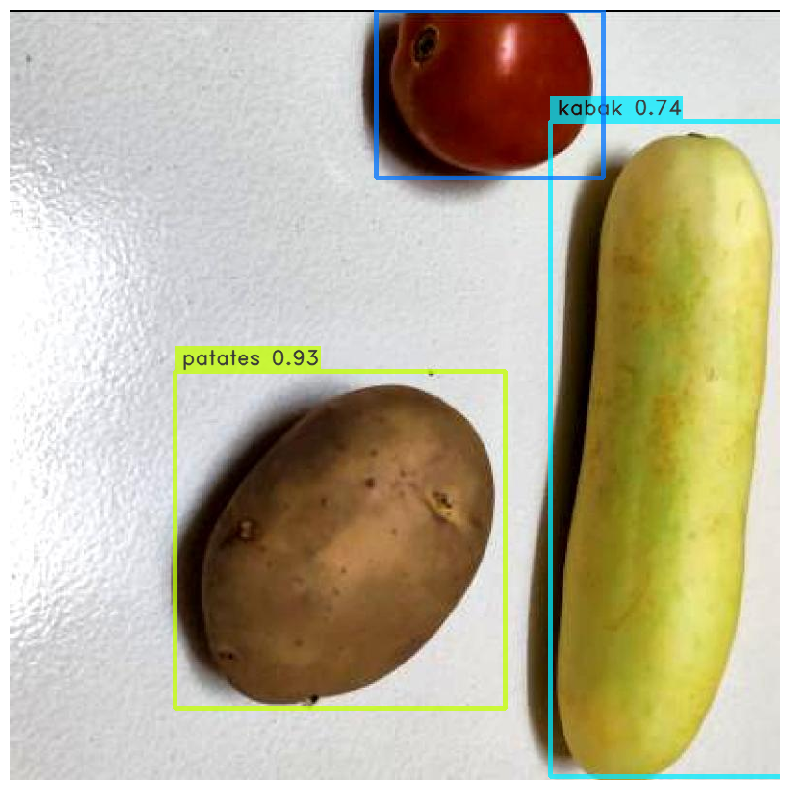

In [41]:
prediction = qat_result.quantized_model.predict(dataset["test"][0]["image"], fuse_model=False)
prediction.show()

# Inference using exported ONNX model

Once QAT is done, we export the model to ONNX format and now it is ready for deployment.
In this example we will use ONNXRuntime to load the model and run inference on a single image.

We can explore the `qat_result.export_result` property to see the details of the exported model and code snippet
to run inference using the exported model:


In [42]:
qat_result.export_result

Model exported successfully to experiments/yolo_nas_s_fridge_cam_qat/yolo_nas_s_fridge_cam_qat_1x3x800x800_qat.onnx
Model expects input image of shape [1, 3, 800, 800]
Input image dtype is torch.uint8
Exported model already contains preprocessing (normalization) step, so you don't need to do it manually.
Preprocessing steps to be applied to input image are:
Sequential(
  (0): CastTensorTo(dtype=torch.float32)
  (1): ChannelSelect(channels_indexes=tensor([2, 1, 0], device='cuda:0'))
  (2): ApplyMeanStd(mean=[0.], scale=[255.])
)

Exported model contains postprocessing (NMS) step with the following parameters:
    num_pre_nms_predictions=1000
    max_predictions_per_image=1000
    nms_threshold=0.65
    confidence_threshold=0.5
    output_predictions_format=batch

Exported model is in ONNX format and can be used with ONNXRuntime
To run inference with ONNXRuntime, please use the following code snippet:

    import onnxruntime
    import numpy as np
    session = onnxruntime.InferenceSessi

An end-to-end example of how to run inference using the exported model is shown below.

**Please keep in mind this is a simple example. We do cut corners here to keep notebook of reasonable size:**

* Batch size is set to 1.
* In a real-world scenario you would want to batch your inference requests to get the best performance from your model.
* Image preprocessing resize image to 640x640 without preserving aspec ratio

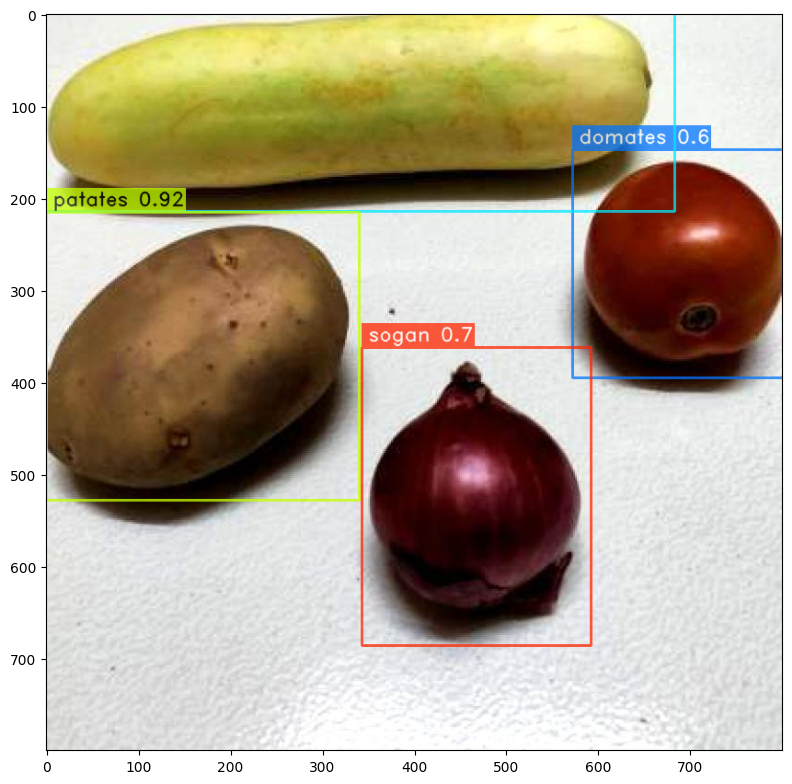

In [48]:
from super_gradients.training.utils.detection_utils import DetectionVisualization
from super_gradients.training.utils.media.image import load_image
import onnxruntime
import numpy as np
import cv2

import matplotlib.pyplot as plt
from super_gradients.inference import iterate_over_detection_predictions_in_batched_format


def show_predictions_from_batch_format(image, predictions):
    image_index, pred_boxes, pred_scores, pred_classes = next(iter(iterate_over_detection_predictions_in_batched_format(predictions)))

    predicted_boxes = np.concatenate([pred_boxes, pred_scores[:, np.newaxis], pred_classes[:, np.newaxis]], axis=1)

    image = DetectionVisualization.visualize_image(image_np=np.array(image), class_names=TRAIN_CLASS_NAMES, pred_boxes=predicted_boxes)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.tight_layout()
    plt.show()


session = onnxruntime.InferenceSession(qat_result.output_onnx_path, providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
inputs = [o.name for o in session.get_inputs()]
outputs = [o.name for o in session.get_outputs()]

image = load_image(dataset["test"][3]["image"])
image = cv2.resize(image, (800, 800))

input_image = np.moveaxis(image, -1, 0)
input_image = np.expand_dims(input_image, axis=0)
predictions = session.run(outputs, {inputs[0]: input_image})

show_predictions_from_batch_format(image, predictions)

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: input for the following indices
 index: 2 Got: 400 Expected: 800
 index: 3 Got: 400 Expected: 800
 Please fix either the inputs or the model.

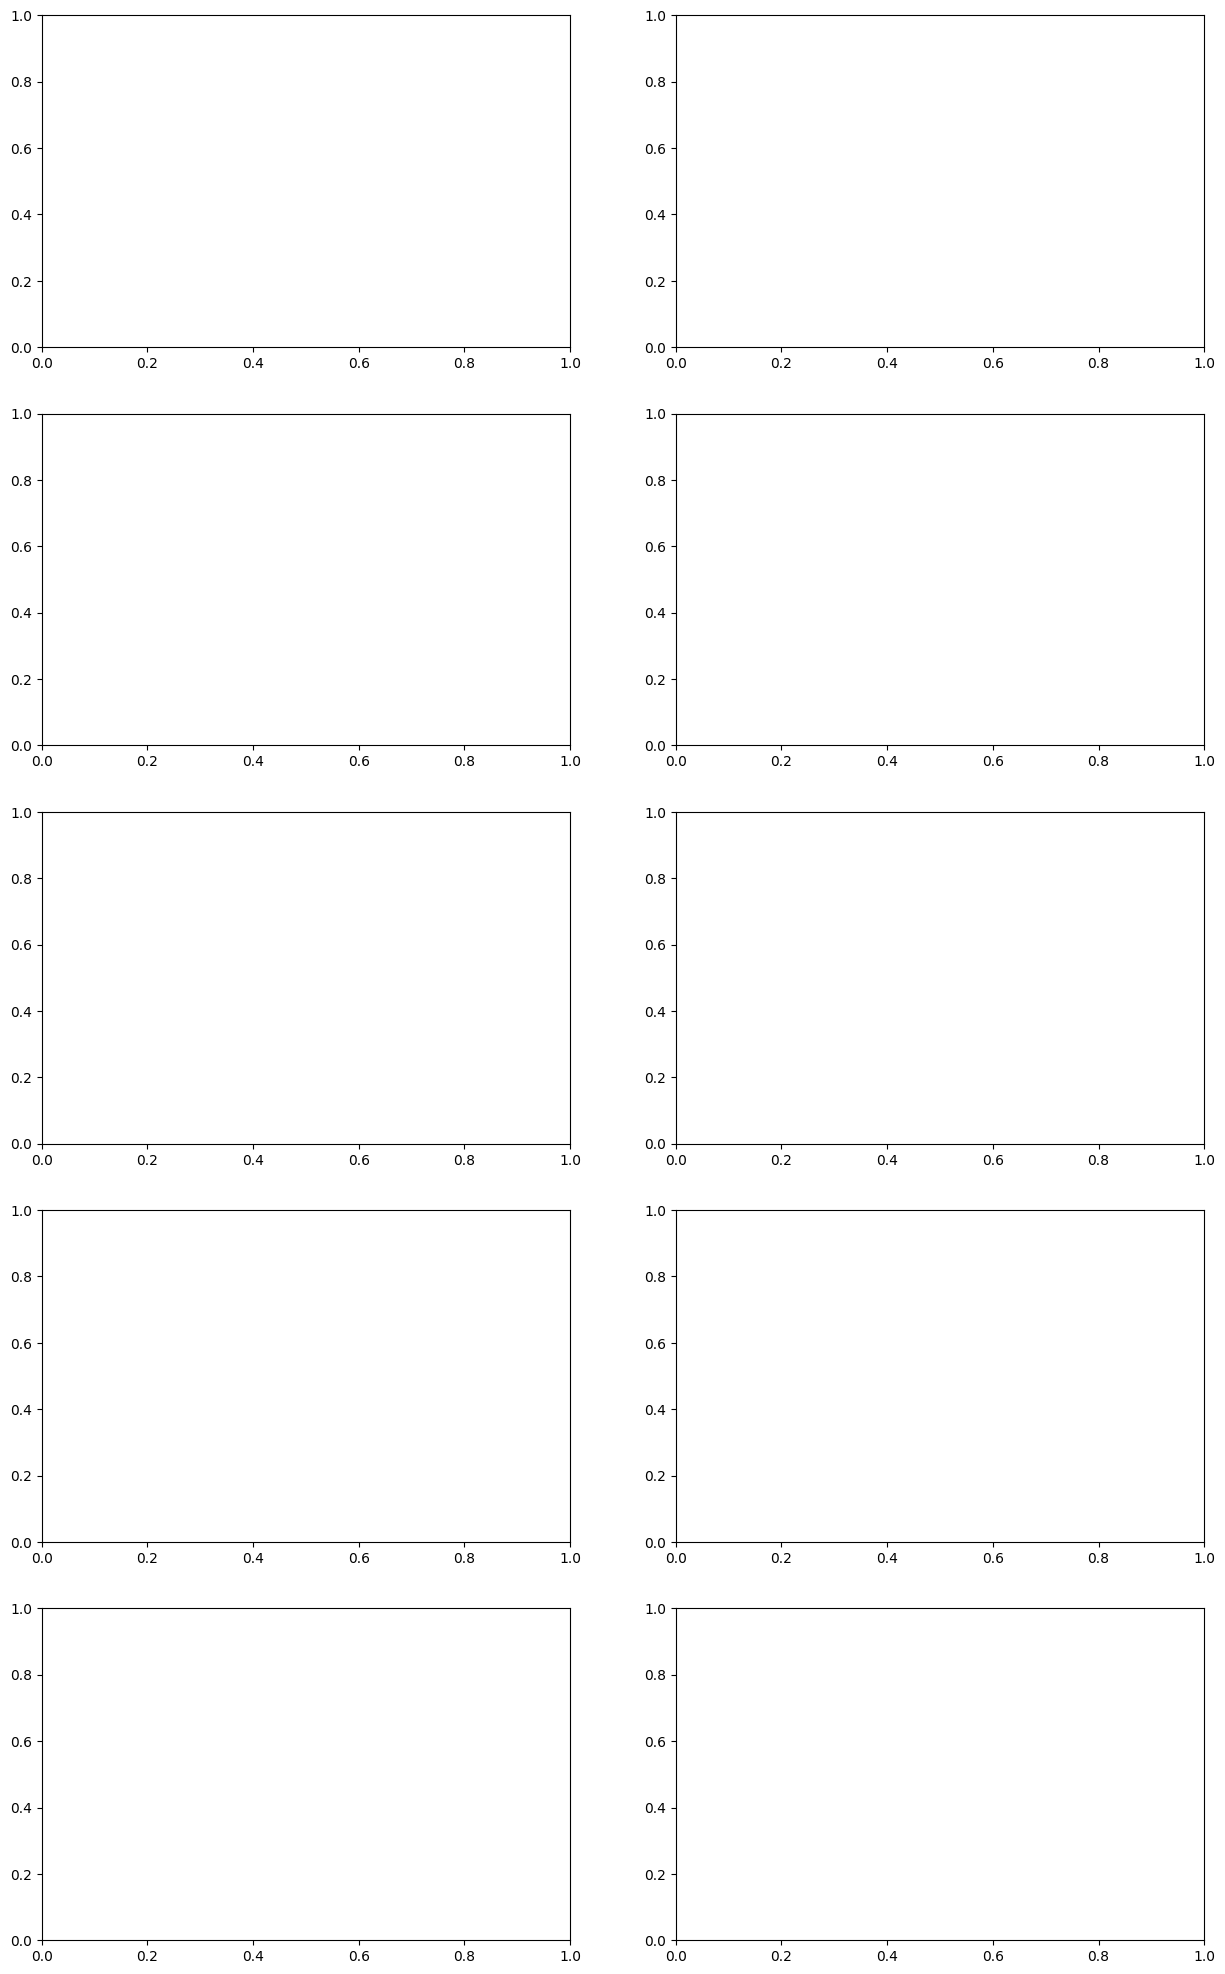

In [52]:
from super_gradients.training.utils.detection_utils import DetectionVisualization
from super_gradients.training.utils.media.image import load_image
import onnxruntime
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from super_gradients.inference import iterate_over_detection_predictions_in_batched_format

def show_predictions_from_batch_format(image, predictions, ax):
    image_index, pred_boxes, pred_scores, pred_classes = next(iter(iterate_over_detection_predictions_in_batched_format(predictions)))

    predicted_boxes = np.concatenate([pred_boxes, pred_scores[:, np.newaxis], pred_classes[:, np.newaxis]], axis=1)

    image = DetectionVisualization.visualize_image(image_np=np.array(image), class_names=TRAIN_CLASS_NAMES, pred_boxes=predicted_boxes)

    ax.imshow(image)
    ax.axis('off')

session = onnxruntime.InferenceSession(qat_result.output_onnx_path, providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
inputs = [o.name for o in session.get_inputs()]
outputs = [o.name for o in session.get_outputs()]

# Rastgele 10 farklı fotoğraf seçimi
num_images = 10
random_indices = random.sample(range(len(dataset["test"])), num_images)

# Sütun sayısı 3, satır sayısını hesapla
cols = 2
rows = (num_images + cols - 1) // cols  # Yuvarlama işlemi

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Otomatik satır sayısı ile grid oluştur

for idx, ax in zip(random_indices, axs.flatten()):
    image = load_image(dataset["test"][idx]["image"])
    image = cv2.resize(image, (800, 800))

    input_image = np.moveaxis(image, -1, 0)
    input_image = np.expand_dims(input_image, axis=0)
    predictions = session.run(outputs, {inputs[0]: input_image})

    show_predictions_from_batch_format(image, predictions, ax)

# Eğer toplam resim sayısı sütun sayısının tam katı değilse, boş kalan hücreleri gizle
for ax in axs.flatten()[num_images:]:
    ax.axis('off')

plt.tight_layout()
plt.show()



# Summary


If we plug them into [netron](https://netron.app), we can see that new blocks that were not a part of the original network were introduced: the **Quantize/Dequantize** layers -

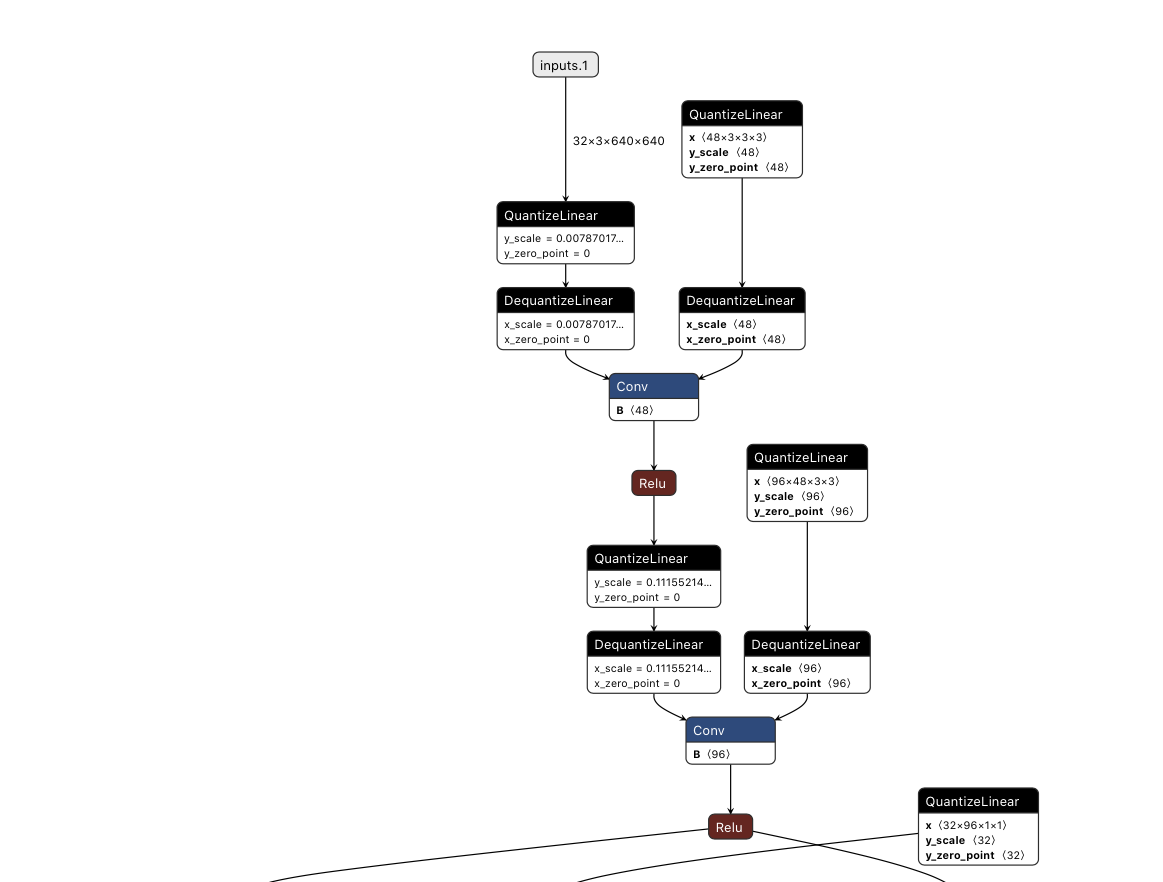

This is expected and a good way to verify that our model is ready to be converted to Int8 using Nvidia's [TesnorRT](https://docs.nvidia.com/deeplearning/tensorrt/quick-start-guide/index.html#deploy-engine):
 We can now use these ONNX files to deploy our newly trained YoloNAS models to production. When building the TRT engine it is important specify that we convert to Int8 (the fake quantized layers in our models will be adapted accordingly), this can be done by running:
`trtexec --fp16 --int8 --onnx=your_yolonas_qat_model.onnx`.

For more information on how to properly export and benchmark YoloNAS, click [here](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/BenchmarkingYoloNAS.md).